In [48]:
#|default_exp batchnorm

In [ ]:
#|export

import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [11]:
test_batch = None
for X, y in trainloader:
    print(X.shape)
    test_batch = X

    break

torch.Size([64, 3, 32, 32])


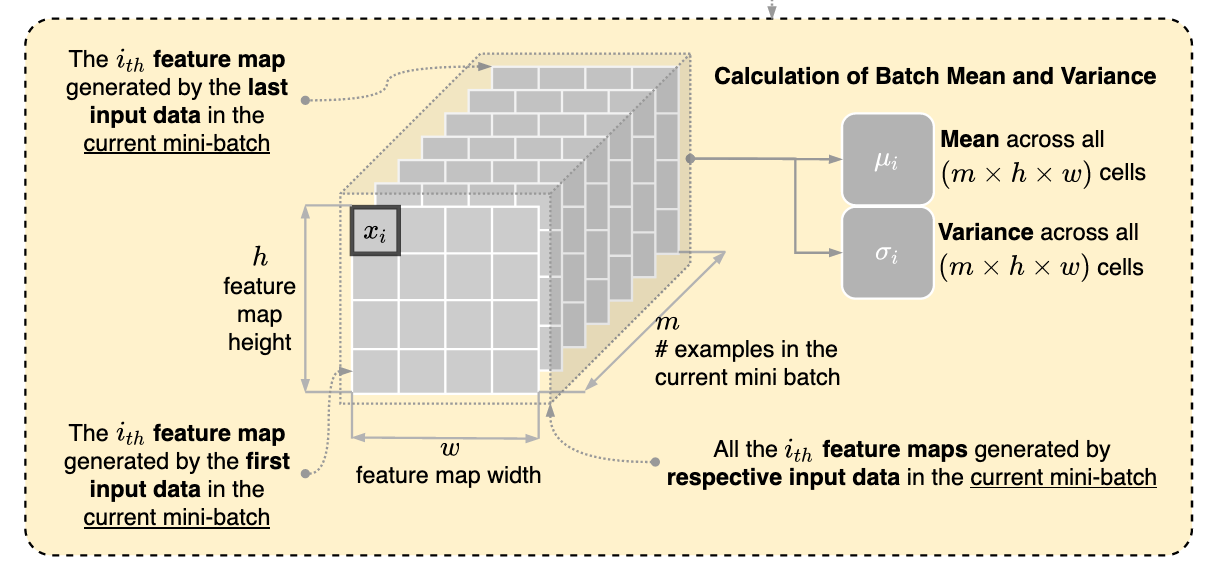

In [ ]:
#|export

class BatchNorm(nn.Module):
    def __init__(self, num_channels=3, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.m = momentum # determines how fast EMA smooths
        self.gamma = nn.Parameter(torch.ones(1, num_channels, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.register_buffer('exponential_mean', torch.zeros(1, num_channels, 1, 1))
        self.register_buffer('exponential_var', torch.ones(1, num_channels, 1, 1))

    def forward(self, X):
        epsilon = self.eps

        if self.training:
            # batch dims: 64 * 3 chan * 32 * 32
            u = torch.mean(X, dim=(0,2,3), keepdim=True)
            var = torch.var(X, dim=(0,2,3), keepdim=True, unbiased=False)

            with torch.no_grad():
                self.exponential_mean.mul_(1 - self.m).add_(self.m * u)
                self.exponential_var.mul_(1 - self.m).add_(self.m * var)
        else:
            u = self.exponential_mean
            var = self.exponential_var

        # mean across the entire block (per channel)
        norm = (X - u) / torch.sqrt(var + epsilon)

        return (self.gamma * norm) + self.beta


In [33]:
normed_X = BatchNorm()(test_batch)
normed_X.shape

torch.Size([64, 3, 32, 32])

In [1]:
from nbdev.export import nb_export 

nb_export('batchnorm.ipynb', '../src/')